In [2]:
from PIL import Image
import pytesseract
import numpy as np

## Sample Inferences of Pytesseract over Whole images

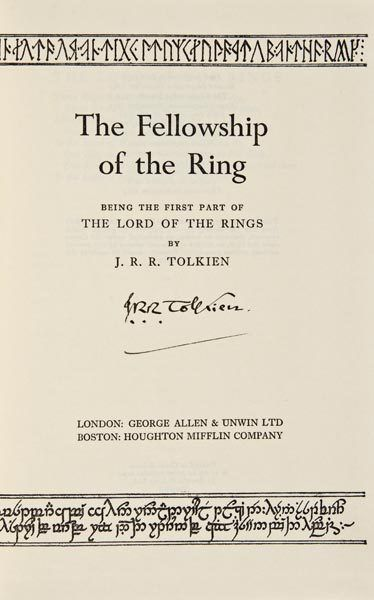

Text image:

BEATRASAINIXG PMNYCENDEYNA BABSNBRANE:

The Fellowship
of the Ring

FING THE PIRST PART OF
‘THE LORD OF THE RINGS

J. RR. TOLKIEN

ee

LONDON: GEORGE ALLEN & UNWIN LD
OSTON; HOUGHTON MIFFLIN COMPANY

aE hah Se eo




In [3]:
image_path = "samples/lotr_cover.jpg"
image = Image.open(image_path)
display(image)
text = pytesseract.image_to_string(image,lang="eng")
print(f"Text image:\n\n{text}")

In [4]:
print(f"Supported languages: {pytesseract.get_languages(config='')}")

Supported languages: ['eng', 'osd', 'spa']


### OCR Latency

Time execution of ocr over original image

In [5]:
print(f"Image shape is: {image.size}")

Image shape is: (374, 600)


In [6]:
%%timeit -r 4 -n 10
pytesseract.image_to_data(image)

248 ms ± 5.79 ms per loop (mean ± std. dev. of 4 runs, 10 loops each)


Time execution over image half its original size

New image shape: (187, 300)



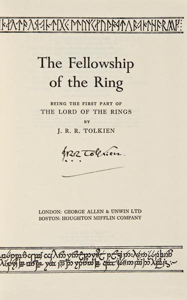

Text from downsized image:

PRASAMANC PYRE

The Fellowship
of the Ring




In [7]:
img_shape = image.size
new_size = int(img_shape[0]*0.5), int(img_shape[1]*0.5)
print(f"New image shape: {new_size}\n")
downsized_image = image.resize(new_size)
display(downsized_image)
text = pytesseract.image_to_string(downsized_image)
print(f"Text from downsized image:\n\n{text}")

Time execution over image a quarter its original size

New image shape: (93, 150)



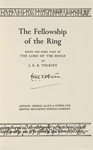

Text from downsized image:




In [8]:
img_shape = image.size
new_size = int(img_shape[0]*0.25), int(img_shape[1]*0.25)
print(f"New image shape: {new_size}\n")
downsized_image = image.resize(new_size)
display(downsized_image)
text = pytesseract.image_to_string(downsized_image)
print(f"Text from downsized image:\n\n{text}")

In [9]:
%%timeit -r 4 -n 10
pytesseract.image_to_data(downsized_image)

100 ms ± 1.02 ms per loop (mean ± std. dev. of 4 runs, 10 loops each)


If comparing results ...

| Extracted Text                                                                                                                                                                                                       | Width | Height | FPS  |
|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------|--------|------|
| BEATRASAINIXG PMNYCENDEYNA BABSNBRANE:  The Fellowship of the Ring  FING THE PIRST PART OF ‘THE LORD OF THE RINGS  J. RR. TOLKIEN  ee  LONDON: GEORGE ALLEN & UNWIN LD OSTON; HOUGHTON MIFFLIN COMPANY  aE hah Se eo | 374   | 600    | 4,06 |
| PRASAMANC PYRE  The Fellowship of the Ring                                                                                                                                                                           | 187   | 300    | 6,80 |
|                                                                                                                                                                                                                      | 93    | 150    | 9,80 |

Overall, it seems clear that pytesseract can't perform well when providing text that is surrounded heavily by background. Text detection and further recognition is reportedly the solution

## Including Text Detection with EAST before recognition

In [36]:
import cv2
import matplotlib.pyplot as plt

EAST_MODEL_PATH = ""
MIN_CONFIDENCE = 0.5
WIDTH = 320 # Must be multiple of 32
HEIGHT = 320 # Must be multiple of 32
MODEL_PATH = "models/frozen_east_text_detection.pb"

image_path = "samples/slant_pc_text_extreme.png"
img = cv2.imread(image_path)
h, w = img.shape[:2]
print(f"Original image size: {(h,w)}")

Original image size: (627, 676)


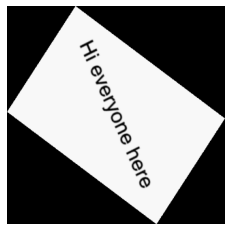

In [37]:
r_w = w / WIDTH
r_h = h / HEIGHT

resized_img = cv2.resize(img, (WIDTH, HEIGHT))
plt.imshow(cv2.cvtColor(resized_img,cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [38]:
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]

# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(MODEL_PATH)

[INFO] loading EAST text detector...


In [39]:
%%time
# construct a blob (preprocessed image for nnet) from the original 
# image and then perform a forward pass of the model to 
# obtain the two output layer sets
blob = cv2.dnn.blobFromImage(
    image = resized_img,
    scalefactor = 1.0,
    size = (WIDTH, HEIGHT),
    mean = (123.68, 116.78, 103.94),
    swapRB=True,
    crop=False
)
# Detect text over
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

CPU times: user 951 ms, sys: 101 ms, total: 1.05 s
Wall time: 197 ms


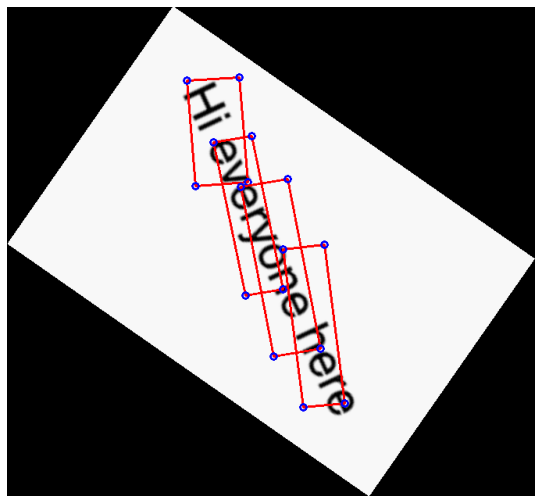

In [48]:
import numpy as np
import math
from imutils.object_detection import non_max_suppression

drawn_img = img.copy()
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
rotated_rects = []
confidences = []

def compute_polar_corner(d1, d2, theta_rect, offset_x, offset_y, corner_id):
    # first we compute the hypotenuse and internal angle of the right triangle
    # formed by the distances to both sides
    hip_tri = math.sqrt(d1**2 + d2**2)
    ang_tri = math.atan(d1/d2)
    # for each corner we have different angles and shifts in relation to rectangle
    # offset
    if corner_id == 1:
        shift_x = -math.cos(theta_rect - ang_tri) * hip_tri
        shift_y = math.sin(theta_rect - ang_tri) * hip_tri
    elif corner_id == 2:
        shift_x = math.cos(theta_rect + ang_tri) * hip_tri
        shift_y = -math.sin(theta_rect + ang_tri) * hip_tri
        
    elif corner_id == 3:
        shift_x = math.cos(theta_rect - ang_tri) * hip_tri
        shift_y = -math.sin(theta_rect - ang_tri) * hip_tri

    elif corner_id == 4:
        shift_x = -math.cos(theta_rect + ang_tri) * hip_tri
        shift_y = math.sin(theta_rect + ang_tri) * hip_tri
    
    # to obtain the final corner coordinates, we apply the previously
    # computed shifts to the coordinates of the rectangle offset
    rx = offset_x + shift_x
    ry = offset_y + shift_y
        
    return rx, ry

box_id = 0
# loop over the number of rows
for y in range(0, numRows):
    # extract the scores (probabilities), followed by the geometrical
    # data used to derive potential bounding box coordinates that
    # surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]
    
   # loop over the number of columns
    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < MIN_CONFIDENCE:
            continue
        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)
        # extract the rotation angle for the prediction
        angle = anglesData[x]
        
        # compute the (x,y) coordinates of the rotated bounding box
        rx1, ry1 = compute_polar_corner(xData0[x],xData3[x], angle, offsetX, offsetY, 1)
        rx2, ry2 = compute_polar_corner(xData0[x],xData1[x], angle, offsetX, offsetY, 2)
        rx3, ry3 = compute_polar_corner(xData2[x],xData1[x], angle, offsetX, offsetY, 3)
        rx4, ry4 = compute_polar_corner(xData2[x],xData3[x], angle, offsetX, offsetY, 4)
        
        
        rotated_rects.append(
            [
                [rx1,ry1],
                [rx2,ry2],
                [rx3,ry3],
                [rx4,ry4],
                [box_id]
            ]
        )
        
        # compute the sin and cosine of the bbox rotation angle
        cos = np.cos(angle)
        sin = np.sin(angle)
        
        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]
        
        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        x2 = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        y2 = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        x1 = int(x2- w)
        y1 = int(y2 - h)
        # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((x1, y1, x2, y2,box_id))
        confidences.append(scoresData[x])
        box_id += 1


# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)

plot_straight_bbox = False
plot_rotated_bbox = True

if plot_straight_bbox:
    # loop over the bounding boxes
    for (x1, y1, x2, y2,_) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        x1 = int(x1 * r_w)
        y1 = int(y1 * r_h)
        x2 = int(x2 * r_w)
        y2 = int(y2 * r_h)
        pts = np.array(
            [
                [x1,y1],
                [x2,y1],
                [x2,y2],
                [x1,y2]
            ],
            dtype=np.int32
        )
        reshaped_pts = pts.reshape((-1, 1, 2))
        cv2.polylines(drawn_img, [reshaped_pts],True,(0,255,0),2)
        for pt in pts:
            cv2.circle(drawn_img, pt,4, (255,0,0),2)
        # draw the bounding box on the image
        #cv2.rectangle(drawn_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

if plot_rotated_bbox:
    selected_box_ids = [box[4] for box in boxes]
    # loop over the rotated bounding boxes
    for box_id in selected_box_ids:
        pts = rotated_rects[box_id]
        scaled_pts = [[int(pt[0]*r_w),int(pt[1]*r_h)] for pt in pts[:4]]
        scaled_pts = np.array(scaled_pts,
            dtype=np.int32
        )
        reshaped_pts = scaled_pts.reshape((-1, 1, 2))
        cv2.polylines(drawn_img, [reshaped_pts],True,(0,0,255),2)
        for pt in scaled_pts:
            cv2.circle(drawn_img, pt,4, (255,0,0),2)
# show the output image
plt.figure(figsize=(12,9))
plt.imshow(cv2.cvtColor(drawn_img, cv2.COLOR_BGR2RGB))
#plt.imshow(drawn_img)
plt.axis("off")
plt.show()

In [26]:
math.cos(0)

1.0